# PSET 1 
Based on Lecture 1 and Lecture 2
Solve for Questions 4 and 5

## Import the necessary dependencies

In [3]:
# Ignore the pip dependecy error

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2d
import scipy.sparse as sps
from PIL import Image
from sys import platform
import sparseqr


In [4]:
! wget http://6.869.csail.mit.edu/fa19/psets19/pset1/img1.png

--2022-02-14 08:16:53--  http://6.869.csail.mit.edu/fa19/psets19/pset1/img1.png
Resolving 6.869.csail.mit.edu... 128.30.100.221
Connecting to 6.869.csail.mit.edu|128.30.100.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96264 (94K) [image/png]
Saving to: 'img1.png.5'

img1.png.5          100%[===================>]  94.01K  --.-KB/s    in 0.04s   

2022-02-14 08:16:53 (2.45 MB/s) - 'img1.png.5' saved [96264/96264]



## 1. Define the Sparse Matrix 

In [128]:
def sparseMatrix(i, j, Aij, imsize):
    """ Build a sparse matrix containing 2D linear neighborhood operators
    Input:
        Aij = [ni, nj, nc] nc: number of neighborhoods with contraints
        i: row index
        j: column index
        imsize: [nrows ncols]
    Returns:
        A: a sparse matrix. Each row contains one 2D linear operator
    """
    ni, nj, nc = Aij.shape
    nij = ni*nj
    
    a = np.zeros((nc*nij))
    m = np.zeros((nc*nij))
    n = np.zeros((nc*nij))
    grid_range = np.arange(-(ni-1)/2, 1+(ni-1)/2)
    jj, ii = np.meshgrid(grid_range, grid_range)
    ii = ii.reshape(-1,order='F')
    jj = jj.reshape(-1,order='F')
    
    
    k = 0
    for c in range(nc):
        # Get matrix index
        x = (i[c]+ii) + (j[c]+jj)*nrows
        a[k:k+nij] = Aij[:,:,c].reshape(-1,order='F')
        m[k:k+nij] = c
        n[k:k+nij] = x
        
        k += nij
    
    m = m.astype(np.int32)
    n = n.astype(np.int32)
    A = sps.csr_matrix((a, (m,  n)))
    
    return A

In [129]:
print(np.cos(alpha))

0.8191520442889918


## 2. Define world parameters and plot the edges

ground (256, 373) [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


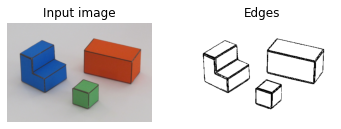

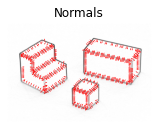

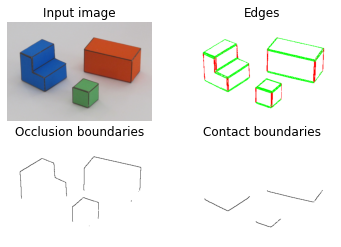

In [130]:
# World parameters
alpha = 35*math.pi/180;

img = cv2.imread('img1.png')
img = img[:, :, ::-1].astype(np.float32)

nrows, ncols, colors = img.shape
ground = (np.min(img, axis=2) > 110).astype(np.float32)
print('ground', ground.shape, ground)
foreground = (ground == 0).astype(np.float32)

m = np.mean(img, 2)
kern = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
dmdx = conv2d(m, kern, 'same')
dmdy = conv2d(m, kern.transpose(), 'same')

mag = np.sqrt(dmdx**2 + dmdy**2)
mag[0, :] = 0
mag[-1, :] = 0
mag[:, 0] = 0
mag[:, -1] = 0

theta = np.arctan2(dmdx, dmdy)
edges = mag >= 30
edges = edges * foreground

## Occlusion and contact edges
pi = math.pi
vertical_edges = edges*((theta<115*pi/180)*(theta>65*pi/180)+(theta<-65*pi/180)*(theta>-115*pi/180));
horizontal_edges = edges * (1-vertical_edges) 

kern = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
horizontal_ground_to_foreground_edges = (conv2d(ground, kern, 'same'))>0;
horizontal_foreground_to_ground_edges = (conv2d(foreground, kern, 'same'))>0;
vertical_ground_to_foreground_edges = vertical_edges*np.abs(conv2d(ground, kern.transpose(), 'same'))>0


occlusion_edges = edges*(vertical_ground_to_foreground_edges + horizontal_ground_to_foreground_edges)
contact_edges   = horizontal_edges*(horizontal_foreground_to_ground_edges);


E = np.concatenate([vertical_edges[:,:,None], 
                    horizontal_edges[:,:,None], 
                    np.zeros(occlusion_edges.shape)[:,:,None]], 2)


# Plot
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title('Input image')
plt.subplot(2,2,2)
plt.imshow(edges == 0, cmap='gray')
plt.axis('off')
plt.title('Edges')

# Normals
K = 3
ey, ex = np.where(edges[::K, ::K])
ex *= K
ey *= K
plt.figure()
plt.subplot(2,2,3)
plt.imshow(np.max(mag)-mag, cmap='gray')
dxe = dmdx[::K, ::K][edges[::K, ::K] > 0]
dye = dmdy[::K, ::K][edges[::K, ::K] > 0]
n = np.sqrt(dxe**2 + dye**2)
dxe = dxe/n
dye = dye/n
plt.quiver(ex, ey, dxe, -dye, color='r')
plt.axis('off')
plt.title('Normals')
plt.show()



# Edges and boundaries
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title('Input image')


plt.subplot(2,2,2)
plt.imshow(E+(edges == 0)[:, :, None])
plt.axis('off')
plt.title('Edges')


plt.subplot(2,2,3)
plt.imshow(1-(occlusion_edges>0), cmap='gray')
plt.axis('off')
plt.title('Occlusion boundaries')

plt.subplot(2,2,4)
plt.imshow(1-contact_edges, cmap='gray')
plt.axis('off')
plt.title('Contact boundaries');



## 3. TODO: Populate edge variables 
Corresponds to Question 4 in the problem set

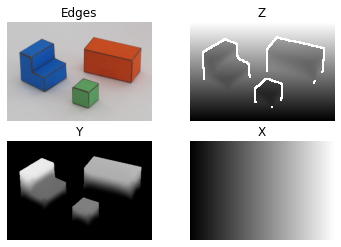

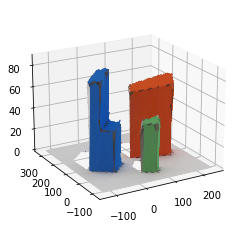

In [131]:
Nconstraints = nrows*ncols*20
Aij = np.zeros((3, 3, Nconstraints))
b = np.zeros((Nconstraints, 1))

#Indices and counters
ii = np.zeros((Nconstraints, 1))
jj = np.zeros((Nconstraints, 1))
global c
c = 0

# These will always be updated with the current indices
def update_indices():
  global c
  ii[c] = i
  jj[c] = j
  c += 1

# Create linear contraints
for i in range(1, nrows-1):
  for j in range(1, ncols-1):
    # Y = 0
    if ground[i,j]:
      Aij[:,:,c] = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
      b[c]       = 0
      update_indices()
    else:
      # Check if current neighborhood touches an edge
      edgesum = np.sum(edges[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches ground pixels
      groundsum = np.sum(ground[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches vertical pixels
      verticalsum = np.sum(vertical_edges[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches horizontal pixels
      horizontalsum = np.sum(horizontal_edges[i-1:i+2,j-1:j+2])

      # TODO: edge orientation (average of edge pixels in current neighborhood)
      # Populate Aij, ii, jj, b, and c using alpha, theta, and 
      # the constraint/transform matrices you derived in the written segment
    
      ###############################################################
      ### COPY YOUR CODE BELOW UNTIL THE LOOP INTO YOUR REPORT ###
      ###############################################################
      
      # Contact edge: dY/dy = ?
      # Requires: a transform matrix
      if contact_edges[i, j]:
        Aij[:,:,c] = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.float32)
        b[c]       = 0 
        update_indices()
      
      # Vertical edge: dY/dy = 1/cos(theta)
      # Requires: a transform matrix, alpha

      if verticalsum > 0 and groundsum == 0:
        Aij[:,:,c] = 0.125*np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
        b[c]       = 1/np.cos(alpha)
        update_indices()
        
      
      # dY/dt = 0 (you'll have to express t using other variables)
      # Requires: a transform matrix, i, j, theta
      if horizontalsum > 0 and groundsum == 0 and verticalsum == 0:
        g_norm = np.sqrt(dmdx[i,j]**2 + dmdy[i,j]**2)
        dmdx_norm = dmdx[i,j]/g_norm
        dmdy_norm = dmdy[i,j]/g_norm
        dx_kern = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
        dy_kern = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
        Aij[:,:,c] = -dx_kern*dmdy_norm +  dy_kern*dmdx_norm
        b[c]       = 0
        update_indices()

      # laplacian = 0 (weighted by 0.1 to reduce constraint strength)
      # Requires: multiple transform matrices
      if groundsum == 0:
        Aij[:,:,c] = 0.1*np.array([[1, -2, 1], [2, -4, 2], [1, -2, 1]], dtype=np.float32)
        b[c]       = 0
        update_indices()

        Aij[:,:,c] = 0.1*np.array([[1, -2, 1], [2, -4, 2], [1, -2, 1]], dtype=np.float32).T
        b[c]       = 0
        update_indices()

        Aij[:,:,c] = 0.1*np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]], dtype=np.float32)
        b[c]       = 0
        update_indices()

# Splve for constraints
ii = ii[:c]
jj = jj[:c]
Aij = Aij[:,:,:c]
b = b[:c]
A = sparseMatrix(ii, jj, Aij, nrows)
Y = sparseqr.solve( A, b)

# Transform vector into image
Y = np.reshape(Y, [nrows, ncols], order='F')

# Recover 3D world coordinates
x, y = np.meshgrid(np.arange(ncols), np.arange(nrows))
x = x.astype(np.float32)
y = y.astype(np.float32)
x -= nrows/2
y -= ncols/2

# Final coordinates
X = x
Z = Y*np.cos(alpha)/np.sin(alpha) - y/np.sin(alpha)
Y = -Y
Y = np.maximum(Y, 0);

E = occlusion_edges.astype(np.float32);
E[E > 0] = np.nan;
Z = Z+E; #  remove occluded edges

# Visualize solution
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img[1:-1, 1:-1].astype(np.uint8))
plt.axis('off')
plt.title('Edges')

plt.subplot(2,2,2)
plt.imshow(Z[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('Z')


plt.subplot(2,2,3)
plt.imshow(Y[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('Y')

plt.subplot(2,2,4)
plt.imshow(X[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('X')

# 3D projection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# TODO (p5/6) Rerun the script with a different image and set a differnt
# view angle. Note that we expect results to be quite brittle -- in
# answering q6, think about the strong assumptions that this approach makes
# we'll see more robust methods for similar problems later in the course

# Specify here the angle you want to see
ax.view_init(20, -120)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

## 4. TODO: Run the code, show new view points for the images included with the code
Corresponds to Question 5 in the Problem Set.

In [149]:
### TODO: Your runs and parameters here
! wget http://6.869.csail.mit.edu/fa19/psets19/pset1/img3.png
img = cv2.imread('img3.png')
img = img[:, :, ::-1].astype(np.float32)

--2022-02-14 09:06:28--  http://6.869.csail.mit.edu/fa19/psets19/pset1/img3.png
Resolving 6.869.csail.mit.edu... 128.30.100.221
Connecting to 6.869.csail.mit.edu|128.30.100.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76434 (75K) [image/png]
Saving to: 'img3.png.4'

img3.png.4          100%[===================>]  74.64K  --.-KB/s    in 0.04s   

2022-02-14 09:06:28 (1.79 MB/s) - 'img3.png.4' saved [76434/76434]



ground (256, 342) [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


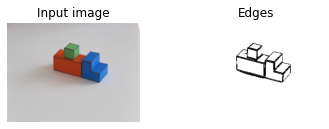

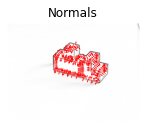

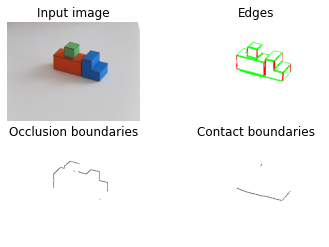

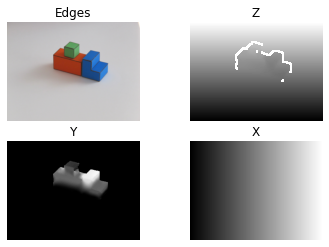

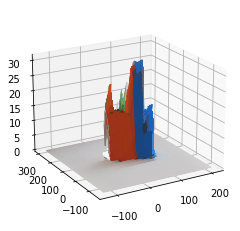

In [150]:
# World parameters
alpha = 35*math.pi/180;

img = cv2.imread('img3.png')
img = img[:, :, ::-1].astype(np.float32)

nrows, ncols, colors = img.shape
ground = (np.min(img, axis=2) > 110).astype(np.float32)
print('ground', ground.shape, ground)
foreground = (ground == 0).astype(np.float32)

m = np.mean(img, 2)
kern = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
dmdx = conv2d(m, kern, 'same')
dmdy = conv2d(m, kern.transpose(), 'same')

mag = np.sqrt(dmdx**2 + dmdy**2)
mag[0, :] = 0
mag[-1, :] = 0
mag[:, 0] = 0
mag[:, -1] = 0

theta = np.arctan2(dmdx, dmdy)
edges = mag >= 30
edges = edges * foreground

## Occlusion and contact edges
pi = math.pi
vertical_edges = edges*((theta<115*pi/180)*(theta>65*pi/180)+(theta<-65*pi/180)*(theta>-115*pi/180));
horizontal_edges = edges * (1-vertical_edges) 

kern = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
horizontal_ground_to_foreground_edges = (conv2d(ground, kern, 'same'))>0;
horizontal_foreground_to_ground_edges = (conv2d(foreground, kern, 'same'))>0;
vertical_ground_to_foreground_edges = vertical_edges*np.abs(conv2d(ground, kern.transpose(), 'same'))>0


occlusion_edges = edges*(vertical_ground_to_foreground_edges + horizontal_ground_to_foreground_edges)
contact_edges   = horizontal_edges*(horizontal_foreground_to_ground_edges);


E = np.concatenate([vertical_edges[:,:,None], 
                    horizontal_edges[:,:,None], 
                    np.zeros(occlusion_edges.shape)[:,:,None]], 2)


# Plot
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title('Input image')
plt.subplot(2,2,2)
plt.imshow(edges == 0, cmap='gray')
plt.axis('off')
plt.title('Edges')

# Normals
K = 3
ey, ex = np.where(edges[::K, ::K])
ex *= K
ey *= K
plt.figure()
plt.subplot(2,2,3)
plt.imshow(np.max(mag)-mag, cmap='gray')
dxe = dmdx[::K, ::K][edges[::K, ::K] > 0]
dye = dmdy[::K, ::K][edges[::K, ::K] > 0]
n = np.sqrt(dxe**2 + dye**2)
dxe = dxe/n
dye = dye/n
plt.quiver(ex, ey, dxe, -dye, color='r')
plt.axis('off')
plt.title('Normals')
plt.show()



# Edges and boundaries
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title('Input image')


plt.subplot(2,2,2)
plt.imshow(E+(edges == 0)[:, :, None])
plt.axis('off')
plt.title('Edges')


plt.subplot(2,2,3)
plt.imshow(1-(occlusion_edges>0), cmap='gray')
plt.axis('off')
plt.title('Occlusion boundaries')

plt.subplot(2,2,4)
plt.imshow(1-contact_edges, cmap='gray')
plt.axis('off')
plt.title('Contact boundaries');


Nconstraints = nrows*ncols*20
Aij = np.zeros((3, 3, Nconstraints))
b = np.zeros((Nconstraints, 1))

#Indices and counters
ii = np.zeros((Nconstraints, 1))
jj = np.zeros((Nconstraints, 1))
global c
c = 0

# These will always be updated with the current indices
def update_indices():
  global c
  ii[c] = i
  jj[c] = j
  c += 1

# Create linear contraints
for i in range(1, nrows-1):
  for j in range(1, ncols-1):
    # Y = 0
    if ground[i,j]:
      Aij[:,:,c] = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
      b[c]       = 0
      update_indices()
    else:
      # Check if current neighborhood touches an edge
      edgesum = np.sum(edges[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches ground pixels
      groundsum = np.sum(ground[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches vertical pixels
      verticalsum = np.sum(vertical_edges[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches horizontal pixels
      horizontalsum = np.sum(horizontal_edges[i-1:i+2,j-1:j+2])

      # TODO: edge orientation (average of edge pixels in current neighborhood)
      # Populate Aij, ii, jj, b, and c using alpha, theta, and 
      # the constraint/transform matrices you derived in the written segment
    
      ###############################################################
      ### COPY YOUR CODE BELOW UNTIL THE LOOP INTO YOUR REPORT ###
      ###############################################################
      
      # Contact edge: dY/dy = ?
      # Requires: a transform matrix
      if contact_edges[i, j]:
        Aij[:,:,c] = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
        b[c]       = 0 
        update_indices()
      
      # Vertical edge: dY/dy = 1/cos(theta)
      # Requires: a transform matrix, alpha

      if verticalsum > 0 and groundsum == 0:
        Aij[:,:,c] = 0.125*np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
        b[c]       = 1/np.cos(alpha)
        update_indices()
        
      
      # dY/dt = 0 (you'll have to express t using other variables)
      # Requires: a transform matrix, i, j, theta
      if horizontalsum > 0 and groundsum == 0 and verticalsum == 0:
        g_norm = np.sqrt(dmdx[i,j]**2 + dmdy[i,j]**2)
        dmdx_norm = dmdx[i,j]/g_norm
        dmdy_norm = dmdy[i,j]/g_norm
        dx_kern = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
        dy_kern = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
        Aij[:,:,c] = -dx_kern*dmdy_norm +  dy_kern*dmdx_norm
        b[c]       = 0
        update_indices()

      # laplacian = 0 (weighted by 0.1 to reduce constraint strength)
      # Requires: multiple transform matrices
      if groundsum == 0:
        Aij[:,:,c] = 0.1*np.array([[1, -2, 1], [2, -4, 2], [1, -2, 1]], dtype=np.float32)
        b[c]       = 0
        update_indices()

        Aij[:,:,c] = 0.1*np.array([[1, -2, 1], [2, -4, 2], [1, -2, 1]], dtype=np.float32).T
        b[c]       = 0
        update_indices()

        Aij[:,:,c] = 0.1*np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]], dtype=np.float32)
        b[c]       = 0
        update_indices()

# Splve for constraints
ii = ii[:c]
jj = jj[:c]
Aij = Aij[:,:,:c]
b = b[:c]
A = sparseMatrix(ii, jj, Aij, nrows)
Y = sparseqr.solve( A, b)

# Transform vector into image
Y = np.reshape(Y, [nrows, ncols], order='F')

# Recover 3D world coordinates
x, y = np.meshgrid(np.arange(ncols), np.arange(nrows))
x = x.astype(np.float32)
y = y.astype(np.float32)
x -= nrows/2
y -= ncols/2

# Final coordinates
X = x
Z = Y*np.cos(alpha)/np.sin(alpha) - y/np.sin(alpha)
Y = -Y
Y = np.maximum(Y, 0);

E = occlusion_edges.astype(np.float32);
E[E > 0] = np.nan;
Z = Z+E; #  remove occluded edges

# Visualize solution
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img[1:-1, 1:-1].astype(np.uint8))
plt.axis('off')
plt.title('Edges')

plt.subplot(2,2,2)
plt.imshow(Z[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('Z')


plt.subplot(2,2,3)
plt.imshow(Y[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('Y')

plt.subplot(2,2,4)
plt.imshow(X[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('X')

# 3D projection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# TODO (p5/6) Rerun the script with a different image and set a differnt
# view angle. Note that we expect results to be quite brittle -- in
# answering q6, think about the strong assumptions that this approach makes
# we'll see more robust methods for similar problems later in the course

# Specify here the angle you want to see
ax.view_init(20, -120)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

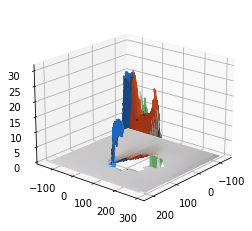

In [151]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 40)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

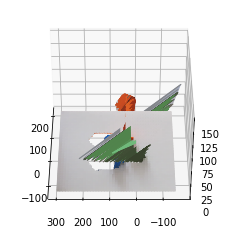

In [147]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, -180)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

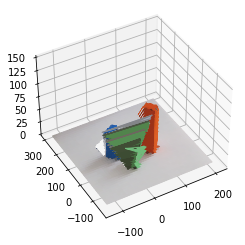

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, -120)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

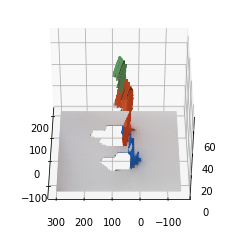

In [125]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, -180)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

In [97]:
! wget http://6.869.csail.mit.edu/fa19/psets19/pset1/img3.png
img = cv2.imread('img3.png')
img = img[:, :, ::-1].astype(np.float32)

--2022-02-13 16:54:05--  http://6.869.csail.mit.edu/fa19/psets19/pset1/img3.png
Resolving 6.869.csail.mit.edu... 128.30.100.221
Connecting to 6.869.csail.mit.edu|128.30.100.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76434 (75K) [image/png]
Saving to: 'img3.png.2'

img3.png.2          100%[===================>]  74.64K  --.-KB/s    in 0.03s   

2022-02-13 16:54:05 (2.25 MB/s) - 'img3.png.2' saved [76434/76434]



ground (256, 342) [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


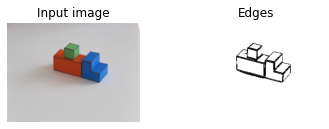

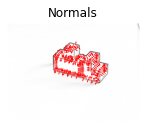

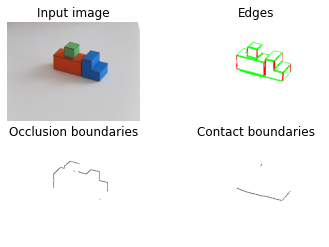

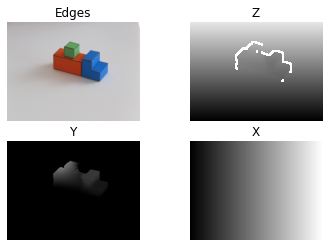

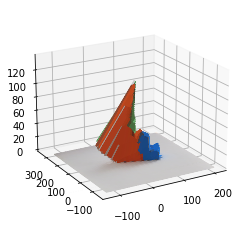

In [98]:
# World parameters
alpha = 35*math.pi/180;

img = cv2.imread('img3.png')
img = img[:, :, ::-1].astype(np.float32)

nrows, ncols, colors = img.shape
ground = (np.min(img, axis=2) > 110).astype(np.float32)
print('ground', ground.shape, ground)
foreground = (ground == 0).astype(np.float32)

m = np.mean(img, 2)
kern = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
dmdx = conv2d(m, kern, 'same')
dmdy = conv2d(m, kern.transpose(), 'same')

mag = np.sqrt(dmdx**2 + dmdy**2)
mag[0, :] = 0
mag[-1, :] = 0
mag[:, 0] = 0
mag[:, -1] = 0

theta = np.arctan2(dmdx, dmdy)
edges = mag >= 30
edges = edges * foreground

## Occlusion and contact edges
pi = math.pi
vertical_edges = edges*((theta<115*pi/180)*(theta>65*pi/180)+(theta<-65*pi/180)*(theta>-115*pi/180));
horizontal_edges = edges * (1-vertical_edges) 

kern = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
horizontal_ground_to_foreground_edges = (conv2d(ground, kern, 'same'))>0;
horizontal_foreground_to_ground_edges = (conv2d(foreground, kern, 'same'))>0;
vertical_ground_to_foreground_edges = vertical_edges*np.abs(conv2d(ground, kern.transpose(), 'same'))>0


occlusion_edges = edges*(vertical_ground_to_foreground_edges + horizontal_ground_to_foreground_edges)
contact_edges   = horizontal_edges*(horizontal_foreground_to_ground_edges);


E = np.concatenate([vertical_edges[:,:,None], 
                    horizontal_edges[:,:,None], 
                    np.zeros(occlusion_edges.shape)[:,:,None]], 2)


# Plot
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title('Input image')
plt.subplot(2,2,2)
plt.imshow(edges == 0, cmap='gray')
plt.axis('off')
plt.title('Edges')

# Normals
K = 3
ey, ex = np.where(edges[::K, ::K])
ex *= K
ey *= K
plt.figure()
plt.subplot(2,2,3)
plt.imshow(np.max(mag)-mag, cmap='gray')
dxe = dmdx[::K, ::K][edges[::K, ::K] > 0]
dye = dmdy[::K, ::K][edges[::K, ::K] > 0]
n = np.sqrt(dxe**2 + dye**2)
dxe = dxe/n
dye = dye/n
plt.quiver(ex, ey, dxe, -dye, color='r')
plt.axis('off')
plt.title('Normals')
plt.show()



# Edges and boundaries
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title('Input image')


plt.subplot(2,2,2)
plt.imshow(E+(edges == 0)[:, :, None])
plt.axis('off')
plt.title('Edges')


plt.subplot(2,2,3)
plt.imshow(1-(occlusion_edges>0), cmap='gray')
plt.axis('off')
plt.title('Occlusion boundaries')

plt.subplot(2,2,4)
plt.imshow(1-contact_edges, cmap='gray')
plt.axis('off')
plt.title('Contact boundaries');


Nconstraints = nrows*ncols*20
Aij = np.zeros((3, 3, Nconstraints))
b = np.zeros((Nconstraints, 1))

#Indices and counters
ii = np.zeros((Nconstraints, 1))
jj = np.zeros((Nconstraints, 1))
global c
c = 0

# These will always be updated with the current indices
def update_indices():
  global c
  ii[c] = i
  jj[c] = j
  c += 1

# Create linear contraints
for i in range(1, nrows-1):
  for j in range(1, ncols-1):
    # Y = 0
    if ground[i,j]:
      Aij[:,:,c] = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
      b[c]       = 0
      update_indices()
    else:
      # Check if current neighborhood touches an edge
      edgesum = np.sum(edges[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches ground pixels
      groundsum = np.sum(ground[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches vertical pixels
      verticalsum = np.sum(vertical_edges[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches horizontal pixels
      horizontalsum = np.sum(horizontal_edges[i-1:i+2,j-1:j+2])

      # TODO: edge orientation (average of edge pixels in current neighborhood)
      # Populate Aij, ii, jj, b, and c using alpha, theta, and 
      # the constraint/transform matrices you derived in the written segment
    
      ###############################################################
      ### COPY YOUR CODE BELOW UNTIL THE LOOP INTO YOUR REPORT ###
      ###############################################################
      
      # Contact edge: dY/dy = ?
      # Requires: a transform matrix
      if contact_edges[i, j]:
        Aij[:,:,c] = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.float32)
        b[c]       = 0 
        update_indices()
      
      # Vertical edge: dY/dy = 1/cos(theta)
      # Requires: a transform matrix, alpha

      if verticalsum > 0 and groundsum == 0:
        Aij[:,:,c] = 0.125*np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
        b[c]       = 1/np.cos(alpha)
        update_indices()
        
      
      # dY/dt = 0 (you'll have to express t using other variables)
      # Requires: a transform matrix, i, j, theta
      if horizontalsum > 0 and groundsum == 0 and verticalsum == 0:
        g_norm = np.sqrt(dmdx[i,j]**2 + dmdy[i,j]**2)
        dmdx_norm = dmdx[i,j]/g_norm
        dmdy_norm = dmdy[i,j]/g_norm
        dx_kern = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
        dy_kern = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
        Aij[:,:,c] = -dx_kern*dmdy_norm +  dy_kern*dmdx_norm
        b[c]       = 0
        update_indices()

      # laplacian = 0 (weighted by 0.1 to reduce constraint strength)
      # Requires: multiple transform matrices
      if groundsum == 0:
        Aij[:,:,c] = 0.1*np.array([[1, -2, 1], [2, -4, 2], [1, -2, 1]], dtype=np.float32)
        b[c]       = 0
        update_indices()

        Aij[:,:,c] = 0.1*np.array([[1, -2, 1], [2, -4, 2], [1, -2, 1]], dtype=np.float32).T
        b[c]       = 0
        update_indices()

        Aij[:,:,c] = 0.1*np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]], dtype=np.float32)
        b[c]       = 0
        update_indices()

# Splve for constraints
ii = ii[:c]
jj = jj[:c]
Aij = Aij[:,:,:c]
b = b[:c]
A = sparseMatrix(ii, jj, Aij, nrows)
Y = sparseqr.solve( A, b)

# Transform vector into image
Y = np.reshape(Y, [nrows, ncols], order='F')

# Recover 3D world coordinates
x, y = np.meshgrid(np.arange(ncols), np.arange(nrows))
x = x.astype(np.float32)
y = y.astype(np.float32)
x -= nrows/2
y -= ncols/2

# Final coordinates
X = x
Z = Y*np.cos(alpha)/np.sin(alpha) - y/np.sin(alpha)
Y = -Y
Y = np.maximum(Y, 0);

E = occlusion_edges.astype(np.float32);
E[E > 0] = np.nan;
Z = Z+E; #  remove occluded edges

# Visualize solution
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img[1:-1, 1:-1].astype(np.uint8))
plt.axis('off')
plt.title('Edges')

plt.subplot(2,2,2)
plt.imshow(Z[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('Z')


plt.subplot(2,2,3)
plt.imshow(Y[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('Y')

plt.subplot(2,2,4)
plt.imshow(X[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('X')

# 3D projection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, -120)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

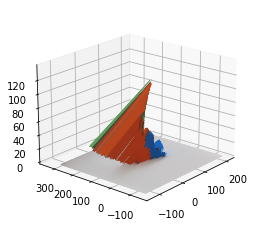

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, -140)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

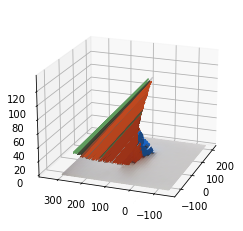

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# TODO (p5/6) Rerun the script with a different image and set a differnt
# view angle. Note that we expect results to be quite brittle -- in
# answering q6, think about the strong assumptions that this approach makes
# we'll see more robust methods for similar problems later in the course

# Specify here the angle you want to see
ax.view_init(20, -160)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

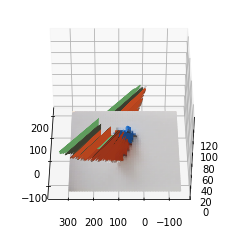

In [101]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, -180)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

In [102]:
! wget http://6.869.csail.mit.edu/fa19/psets19/pset1/img4.png
img = cv2.imread('img4.png')
img = img[:, :, ::-1].astype(np.float32)

--2022-02-13 16:55:20--  http://6.869.csail.mit.edu/fa19/psets19/pset1/img4.png
Resolving 6.869.csail.mit.edu... 128.30.100.221
Connecting to 6.869.csail.mit.edu|128.30.100.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78473 (77K) [image/png]
Saving to: 'img4.png.1'

img4.png.1          100%[===================>]  76.63K  --.-KB/s    in 0.04s   

2022-02-13 16:55:20 (2.11 MB/s) - 'img4.png.1' saved [78473/78473]



ground (256, 342) [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


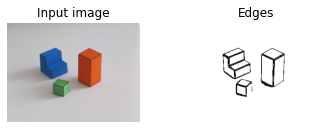

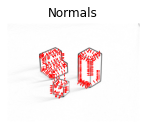

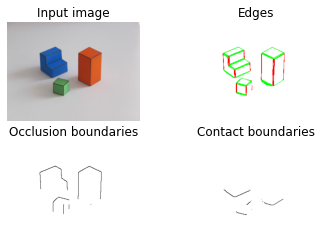

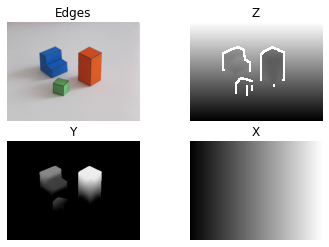

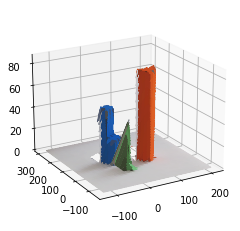

In [103]:
# World parameters
alpha = 35*math.pi/180;

img = cv2.imread('img4.png')
img = img[:, :, ::-1].astype(np.float32)

nrows, ncols, colors = img.shape
ground = (np.min(img, axis=2) > 110).astype(np.float32)
print('ground', ground.shape, ground)
foreground = (ground == 0).astype(np.float32)

m = np.mean(img, 2)
kern = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
dmdx = conv2d(m, kern, 'same')
dmdy = conv2d(m, kern.transpose(), 'same')

mag = np.sqrt(dmdx**2 + dmdy**2)
mag[0, :] = 0
mag[-1, :] = 0
mag[:, 0] = 0
mag[:, -1] = 0

theta = np.arctan2(dmdx, dmdy)
edges = mag >= 30
edges = edges * foreground

## Occlusion and contact edges
pi = math.pi
vertical_edges = edges*((theta<115*pi/180)*(theta>65*pi/180)+(theta<-65*pi/180)*(theta>-115*pi/180));
horizontal_edges = edges * (1-vertical_edges) 

kern = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
horizontal_ground_to_foreground_edges = (conv2d(ground, kern, 'same'))>0;
horizontal_foreground_to_ground_edges = (conv2d(foreground, kern, 'same'))>0;
vertical_ground_to_foreground_edges = vertical_edges*np.abs(conv2d(ground, kern.transpose(), 'same'))>0


occlusion_edges = edges*(vertical_ground_to_foreground_edges + horizontal_ground_to_foreground_edges)
contact_edges   = horizontal_edges*(horizontal_foreground_to_ground_edges);


E = np.concatenate([vertical_edges[:,:,None], 
                    horizontal_edges[:,:,None], 
                    np.zeros(occlusion_edges.shape)[:,:,None]], 2)


# Plot
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title('Input image')
plt.subplot(2,2,2)
plt.imshow(edges == 0, cmap='gray')
plt.axis('off')
plt.title('Edges')

# Normals
K = 3
ey, ex = np.where(edges[::K, ::K])
ex *= K
ey *= K
plt.figure()
plt.subplot(2,2,3)
plt.imshow(np.max(mag)-mag, cmap='gray')
dxe = dmdx[::K, ::K][edges[::K, ::K] > 0]
dye = dmdy[::K, ::K][edges[::K, ::K] > 0]
n = np.sqrt(dxe**2 + dye**2)
dxe = dxe/n
dye = dye/n
plt.quiver(ex, ey, dxe, -dye, color='r')
plt.axis('off')
plt.title('Normals')
plt.show()



# Edges and boundaries
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title('Input image')


plt.subplot(2,2,2)
plt.imshow(E+(edges == 0)[:, :, None])
plt.axis('off')
plt.title('Edges')


plt.subplot(2,2,3)
plt.imshow(1-(occlusion_edges>0), cmap='gray')
plt.axis('off')
plt.title('Occlusion boundaries')

plt.subplot(2,2,4)
plt.imshow(1-contact_edges, cmap='gray')
plt.axis('off')
plt.title('Contact boundaries');


Nconstraints = nrows*ncols*20
Aij = np.zeros((3, 3, Nconstraints))
b = np.zeros((Nconstraints, 1))

#Indices and counters
ii = np.zeros((Nconstraints, 1))
jj = np.zeros((Nconstraints, 1))
global c
c = 0

# These will always be updated with the current indices
def update_indices():
  global c
  ii[c] = i
  jj[c] = j
  c += 1

# Create linear contraints
for i in range(1, nrows-1):
  for j in range(1, ncols-1):
    # Y = 0
    if ground[i,j]:
      Aij[:,:,c] = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
      b[c]       = 0
      update_indices()
    else:
      # Check if current neighborhood touches an edge
      edgesum = np.sum(edges[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches ground pixels
      groundsum = np.sum(ground[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches vertical pixels
      verticalsum = np.sum(vertical_edges[i-1:i+2,j-1:j+2])
      # Check if current neirborhood touches horizontal pixels
      horizontalsum = np.sum(horizontal_edges[i-1:i+2,j-1:j+2])

      # TODO: edge orientation (average of edge pixels in current neighborhood)
      # Populate Aij, ii, jj, b, and c using alpha, theta, and 
      # the constraint/transform matrices you derived in the written segment
    
      ###############################################################
      ### COPY YOUR CODE BELOW UNTIL THE LOOP INTO YOUR REPORT ###
      ###############################################################
      
      # Contact edge: dY/dy = ?
      # Requires: a transform matrix
      if contact_edges[i, j]:
        Aij[:,:,c] = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.float32)
        b[c]       = 0 
        update_indices()
      
      # Vertical edge: dY/dy = 1/cos(theta)
      # Requires: a transform matrix, alpha

      if verticalsum > 0 and groundsum == 0:
        Aij[:,:,c] = 0.125*np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
        b[c]       = 1/np.cos(alpha)
        update_indices()
        
      
      # dY/dt = 0 (you'll have to express t using other variables)
      # Requires: a transform matrix, i, j, theta
      if horizontalsum > 0 and groundsum == 0 and verticalsum == 0:
        g_norm = np.sqrt(dmdx[i,j]**2 + dmdy[i,j]**2)
        dmdx_norm = dmdx[i,j]/g_norm
        dmdy_norm = dmdy[i,j]/g_norm
        dx_kern = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
        dy_kern = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
        Aij[:,:,c] = -dx_kern*dmdy_norm +  dy_kern*dmdx_norm
        b[c]       = 0
        update_indices()

      # laplacian = 0 (weighted by 0.1 to reduce constraint strength)
      # Requires: multiple transform matrices
      if groundsum == 0:
        Aij[:,:,c] = 0.1*np.array([[1, -2, 1], [2, -4, 2], [1, -2, 1]], dtype=np.float32)
        b[c]       = 0
        update_indices()

        Aij[:,:,c] = 0.1*np.array([[1, -2, 1], [2, -4, 2], [1, -2, 1]], dtype=np.float32).T
        b[c]       = 0
        update_indices()

        Aij[:,:,c] = 0.1*np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]], dtype=np.float32)
        b[c]       = 0
        update_indices()

# Splve for constraints
ii = ii[:c]
jj = jj[:c]
Aij = Aij[:,:,:c]
b = b[:c]
A = sparseMatrix(ii, jj, Aij, nrows)
Y = sparseqr.solve( A, b)

# Transform vector into image
Y = np.reshape(Y, [nrows, ncols], order='F')

# Recover 3D world coordinates
x, y = np.meshgrid(np.arange(ncols), np.arange(nrows))
x = x.astype(np.float32)
y = y.astype(np.float32)
x -= nrows/2
y -= ncols/2

# Final coordinates
X = x
Z = Y*np.cos(alpha)/np.sin(alpha) - y/np.sin(alpha)
Y = -Y
Y = np.maximum(Y, 0);

E = occlusion_edges.astype(np.float32);
E[E > 0] = np.nan;
Z = Z+E; #  remove occluded edges

# Visualize solution
plt.figure()
plt.subplot(2,2,1)
plt.imshow(img[1:-1, 1:-1].astype(np.uint8))
plt.axis('off')
plt.title('Edges')

plt.subplot(2,2,2)
plt.imshow(Z[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('Z')


plt.subplot(2,2,3)
plt.imshow(Y[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('Y')

plt.subplot(2,2,4)
plt.imshow(X[1:-1, 1:-1], cmap='gray')
plt.axis('off')
plt.title('X')

# 3D projection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, -120)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

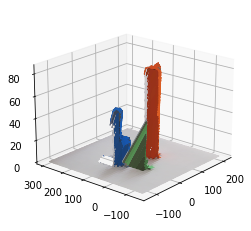

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, -140)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

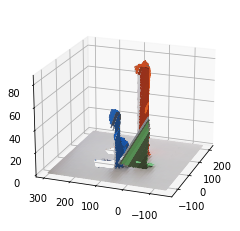

In [105]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, -160)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

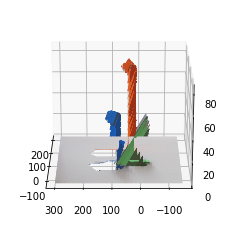

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, -180)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)

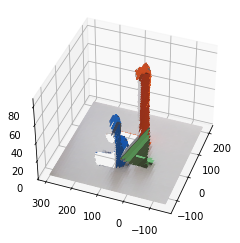

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, -160)
ax.plot_surface(X,Z,Y, facecolors=img/255., shade=False)